# かがわAIゼミナール2019
## 課題１ : kickstarter-projects
## クラウドファンデイングが成功するか(state)を予測

#### DATA:kaggle   https://www.kaggle.com/kemical/kickstarter-projects
#### 注意点）　説明変数は現時点でわかっている情報だけを使用すること

In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression, LassoCV, LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from datetime import datetime, date
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils

In [84]:
# データ読み込み
df = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv") 
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### 課題の精度基準を統一するため、最初に学習データとテストデータを作る

In [85]:
df = df[df["state"]!="live"]
df["state"] = df["state"]=="successful"
df_X = df.drop("state", axis=1)
X = df_X.values
y = df["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

##### 目的変数
- state : この課題ではsuccessful（成功）、その他（失敗）とする
    
##### 説明変数
- ID
- name
- category
- main_category
- currency : 通貨
- deadline : 締め切り日
- goal : Goal amount in project currency : プロジェクト通貨での目標額
- launched : 開始日時
- pledged : Pledged amount in the project currency : プロジェクト通貨での元本額
- backers : 支援者数
- country : 国
- usd pledged : Pledged amount in USD (conversion made by KS) : 担保金額（米ドル）（KSによる変換）
- usd_pledged_real : Pledged amount in USD (conversion made by fixer.io api) : 担保金額（米ドル）
- usd_goal_real : Goal amount in USD : 目標額（米ドル）

学習データを前処理できる形に戻す

In [86]:
# 変数名取得
X_columns_nm = df_X.columns
y_columns_nm = ["state"]
# DataFrameに変換
df_X_train = pd.DataFrame(X_train, columns=X_columns_nm)
df_y_train = pd.DataFrame(y_train, columns=y_columns_nm)
df_X_test = pd.DataFrame(X_test, columns=X_columns_nm)
# 学習データを再結合
df_train = df_X_train.copy()
df_train["state"] = df_y_train["state"]
df_train.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state
0,1214642345,"""Faith Lost"" a short film",Film & Video,Film & Video,USD,2014-07-03,5000,2014-06-03 21:55:09,0,0,US,0,0,5000,False
1,755695046,The Appearing,Narrative Film,Film & Video,USD,2011-12-10,20000,2011-10-11 01:21:25,160,4,US,160,160,20000,False
2,447601652,"Help us take Swirl + Sparkle to QVC, HSN and b...",Product Design,Design,USD,2016-09-29,15000,2016-08-30 17:53:27,3336,44,US,683,3336,15000,False
3,1754863007,TEX-SHIELD The legend of a Texas Superhero,Comics,Comics,USD,2011-08-30,15000,2011-07-01 02:26:12,225,7,US,225,225,15000,False
4,1755007866,Meow Meow ( A Cat Cafe ),Events,Food,USD,2015-10-01,20000,2015-08-30 22:49:34,767,12,US,767,767,20000,False


- プロジェクトスタート時に取得できない情報、"backers", "pledged", "usd pledged", "usd_pledged_real"　→　削除
- "goal" は通貨を合わせる為、"usd_goal_real"を使用する。"goal"は使用しない
- "ID" は一意な連続キーである為、分類に関係ないと判断し、学習に使用しない

In [87]:
# 学習、テストデータから上記説明変数を削除
df_train = df_train.drop(['ID', 'backers', 'pledged', 'usd pledged', 'usd_pledged_real', 'goal'], axis=1)
df_X_test = df_X_test.drop(['ID', 'backers', 'pledged', 'usd pledged', 'usd_pledged_real', 'goal'], axis=1)

### 基本情報確認

In [88]:
# 行列数確認
print("train:{}".format(df_train.shape))
print('-'*30)
print("test:{}".format(df_X_test.shape))

train:(300689, 9)
------------------------------
test:(75173, 8)


In [89]:
# 基本情報
df_train.info()
print('-'*60)
df_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300689 entries, 0 to 300688
Data columns (total 9 columns):
name             300686 non-null object
category         300689 non-null object
main_category    300689 non-null object
currency         300689 non-null object
deadline         300689 non-null object
launched         300689 non-null object
country          300689 non-null object
usd_goal_real    300689 non-null object
state            300689 non-null bool
dtypes: bool(1), object(8)
memory usage: 18.6+ MB
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75173 entries, 0 to 75172
Data columns (total 8 columns):
name             75172 non-null object
category         75173 non-null object
main_category    75173 non-null object
currency         75173 non-null object
deadline         75173 non-null object
launched         75173 non-null object
country          75173 non-null object
usd_goal_real    75173 non-null object
d

In [90]:
# 学習データを元の型に戻しておく
df.info()
print('-'*60)
df_train[["usd_goal_real"]] = df_train[["usd_goal_real"]].astype(np.float64)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375862 entries, 0 to 378660
Data columns (total 15 columns):
ID                  375862 non-null int64
name                375858 non-null object
category            375862 non-null object
main_category       375862 non-null object
currency            375862 non-null object
deadline            375862 non-null object
goal                375862 non-null float64
launched            375862 non-null object
pledged             375862 non-null float64
state               375862 non-null bool
backers             375862 non-null int64
country             375862 non-null object
usd pledged         372066 non-null float64
usd_pledged_real    375862 non-null float64
usd_goal_real       375862 non-null float64
dtypes: bool(1), float64(5), int64(2), object(7)
memory usage: 43.4+ MB
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300689 entries, 0 to 300688
Data columns (total 9 columns):


#### 欠損値の確認

In [91]:
# 欠損値がないか確認
print(df_train.isnull().sum())
print('-'*40)
print(df_X_test.isnull().sum())

name             3
category         0
main_category    0
currency         0
deadline         0
launched         0
country          0
usd_goal_real    0
state            0
dtype: int64
----------------------------------------
name             1
category         0
main_category    0
currency         0
deadline         0
launched         0
country          0
usd_goal_real    0
dtype: int64


学習データには、nameに3行欠損値があり、
テストデータには、nameに１行欠損値がある

In [92]:
df_train_name_null = df_train[df_train["name"].isnull()]
df_train_name_null

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,state
1036,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,GB,3224.97,False
193855,NaN,Product Design,Design,USD,2016-07-18,2016-06-18 05:01:47,US,2500.00,False
221438,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,US,200000.00,False


In [93]:
df_test_name_null = df_X_test[df_X_test["name"].isnull()]
df_test_name_null

,name,category,main_category,currency,deadline,launched,country,usd_goal_real
27421,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,US,35000


学習データは３０万件あり、十分なデータ数である為、nameがNaNである行を削除する

In [94]:
df_train = df_train.dropna(subset = ['name'])

In [95]:
# 統計量表示
df_train.describe(include='all')

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,state
count,300686,300686,300686,300686,300686,300686,300686,3.006860e+05,300686
unique,298744,159,15,14,3136,300313,23,NaN,2
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,US,NaN,False
freq,33,17755,50764,234725,559,6,232510,NaN,193427
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.580336e+04,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.174873e+06,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.452030e+03,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.550000e+04,NaN


##### →　説明変数の特徴
- nameは同じ名前もある
- categoryは159カテゴリ、main_categoryは15カテゴリ
- currency（通貨）はUSDが７８％を占める
- countyは23カ国でUSが７７％を占める
- stateから３分の１が成功、３分の２が成功しないデータである
- launched にはシステム日付’1970-01-01’が含まれている事が分かる
- deadline と launched がこのままでは使えそうにない　→　期間を新たな説明変数として追加する
- usd_goal_real は0.01ドル〜160,000,000ドルの範囲

開始日のシステム日付のデータを削除する

In [96]:
# 開始日のシステム日付をソート表示
df_train.sort_values('launched')

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,state
295181,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,1970-01-01 01:00:00,US,4000.00,False
42189,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,1970-01-01 01:00:00,US,15000.00,False
125989,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,1970-01-01 01:00:00,US,10000.00,False
178848,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,1970-01-01 01:00:00,US,700.00,False
176269,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,1970-01-01 01:00:00,US,5000.00,False
215871,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,1970-01-01 01:00:00,US,500.00,False
58155,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,2009-04-21 21:02:48,US,1000.00,False
274879,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,2009-04-23 00:07:53,US,80000.00,False
58173,drawing for dollars,Illustration,Art,USD,2009-05-03,2009-04-24 21:52:03,US,20.00,True
121506,Offline Wikipedia iPhone app,Software,Technology,USD,2009-07-14,2009-04-25 17:36:21,US,99.00,True


In [97]:
df_train[df_train['launched'] < '1970-01-02']

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,state
42189,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,1970-01-01 01:00:00,US,15000.0,False
125989,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,1970-01-01 01:00:00,US,10000.0,False
176269,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,1970-01-01 01:00:00,US,5000.0,False
178848,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,1970-01-01 01:00:00,US,700.0,False
215871,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,1970-01-01 01:00:00,US,500.0,False
295181,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,1970-01-01 01:00:00,US,4000.0,False


In [98]:
# 開始日のシステム日付のデータを削除する
df_train = df_train[df_train['launched'] > '1970-01-02']

クラウドファウンディングの募集期間は成功に関係が少しありそうなので、期間を説明変数に追加、使用しない"deadline","launched"を削除。
 - 資金を集められる期間（開始日と締め切り日の差(day_diff)）：deadline - launched

In [99]:
# day_diff : 資金を集められる期間( = deadline - launched)（オリジナル）
# 文字列データをdatetimeに変換
df_train['deadline'] = df_train['deadline'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
df_train['launched'] = df_train['launched'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
# 日数の差
day_diff = (df_train['deadline'] - df_train['launched']).apply(lambda x: x.days)
# 追加
df_train['day_diff'] = day_diff
df_train = df_train.drop(['deadline','launched'], axis=1)

In [100]:
# テストデータも同様に実施
df_X_test['deadline'] = df_X_test['deadline'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
df_X_test['launched'] = df_X_test['launched'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
day_diff = (df_X_test['deadline'] - df_X_test['launched']).apply(lambda x: x.days)
df_X_test['day_diff'] = day_diff
df_X_test = df_X_test.drop(['deadline','launched'], axis=1)

In [101]:
df_train

,name,category,main_category,currency,country,usd_goal_real,state,day_diff
0,"""Faith Lost"" a short film",Film & Video,Film & Video,USD,US,5000.00,False,30
1,The Appearing,Narrative Film,Film & Video,USD,US,20000.00,False,60
2,"Help us take Swirl + Sparkle to QVC, HSN and b...",Product Design,Design,USD,US,15000.00,False,30
3,TEX-SHIELD The legend of a Texas Superhero,Comics,Comics,USD,US,15000.00,False,60
4,Meow Meow ( A Cat Cafe ),Events,Food,USD,US,20000.00,False,32
5,"""Get Gone"" Music Video (Canceled)",Shorts,Film & Video,USD,US,2000.00,False,25
6,"Spectral Cinema: the ""Spirit Saints"" series by...",Photography,Photography,USD,US,1700.00,True,33
7,Warm Puppy,Pet Fashion,Fashion,USD,US,5000.00,False,30
8,Pedal powered ride for the Fort Wayne Regional...,Sculpture,Art,USD,US,3000.00,False,20
9,CABARET,Theater,Theater,USD,US,15000.00,False,36


基礎データより

- nameから単語数をカウントし新しい特徴量としてみては？



In [102]:
# 分割してみる
df_train_name = df_train[['name','state']]
df_train_name['name'] = df_train_name['name'].str.split()

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
# 中身を確認
df_train_name['name']

0                           ["Faith, Lost", a, short, film]
1                                          [The, Appearing]
2         [Help, us, take, Swirl, +, Sparkle, to, QVC,, ...
3         [TEX-SHIELD, The, legend, of, a, Texas, Superh...
4                          [Meow, Meow, (, A, Cat, Cafe, )]
5                   ["Get, Gone", Music, Video, (Canceled)]
6         [Spectral, Cinema:, the, "Spirit, Saints", ser...
7                                             [Warm, Puppy]
8         [Pedal, powered, ride, for, the, Fort, Wayne, ...
9                                                 [CABARET]
10                                   [Love's, Bitter, Lies]
11        [[, The, Soulless, Machine, ], -, an, MFA, the...
12                              [And, Everyone, Was, There]
13                       [Fulanito, -, Xientifico, Remixes]
14           [Osamu:, Rock, con, Sabor, Direct, from, Cuba]
15                                     [Sick, with, desire]
16        [Laugh, Your, Age, Off--You, T

In [104]:
df_train['name_word_len'] = df_train_name['name'].str.len()

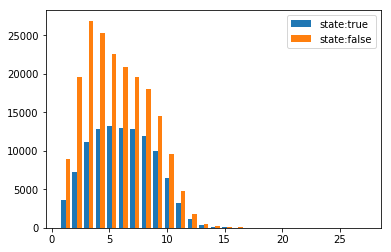

In [105]:
# 成功・失敗の単語数別グラフを表示
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
id_x1 = df_train[df_train['state']]['name_word_len'].value_counts().index
id_y1 = df_train[df_train['state']]['name_word_len'].value_counts().values
id_x0 = df_train[~df_train['state']]['name_word_len'].value_counts().index
id_y0 = df_train[~df_train['state']]['name_word_len'].value_counts().values

ax.bar(id_x1,id_y1, width=0.4, label='state:true')
ax.bar(id_x0 + 0.4,id_y0, width=0.4, label='state:false')
ax.legend()
plt.show()

→　名前（単語数）によって成功割合が変わっている。

In [106]:
# name列を削除
df_train = df_train.drop('name', axis=1)
df_train.head()

,category,main_category,currency,country,usd_goal_real,state,day_diff,name_word_len
0,Film & Video,Film & Video,USD,US,5000.0,False,30,5
1,Narrative Film,Film & Video,USD,US,20000.0,False,60,2
2,Product Design,Design,USD,US,15000.0,False,30,11
3,Comics,Comics,USD,US,15000.0,False,60,7
4,Events,Food,USD,US,20000.0,False,32,7


In [107]:
# testデータに対しても実施
df_X_test['name'] = df_X_test['name'].str.split()
df_X_test['name_word_len'] = df_X_test['name'].str.len()
df_X_test = df_X_test.drop('name', axis=1)

In [108]:
# テストデータのnameにはNaN値が１件ある為、単語のカウント数を0にしておく
df_X_test['name_word_len'] = df_X_test['name_word_len'].fillna(0)

### カテゴリ変数をダミー変数に変換（One-Hotベクトル）

In [109]:
# カテゴリーについて、メインカテゴリを使うか詳細なカテゴリを使うか
print(df_train['category'].value_counts())
# 159種
print('-'*60)
print(df_train['main_category'].value_counts())
# 15種
#  →　種類の少ないmain_categoryを使用してみる

Product Design       17755
Documentary          12953
Music                12480
Tabletop Games       11183
Shorts                9852
Video Games           9328
Food                  9216
Film & Video          8131
Fiction               7304
Fashion               6821
Nonfiction            6575
Art                   6504
Apparel               5640
Theater               5620
Technology            5528
Rock                  5433
Children's Books      5298
Apps                  5022
Publishing            4714
Webseries             4616
Photography           4591
Indie Rock            4524
Narrative Film        4093
Web                   4052
Comics                3978
Crafts                3707
Country & Folk        3531
Design                3328
Hip-Hop               3126
Hardware              2917
                     ...  
Couture                211
Blues                  206
Makerspaces            201
Movie Theaters         198
Animals                196
Fabrication Tools      195
P

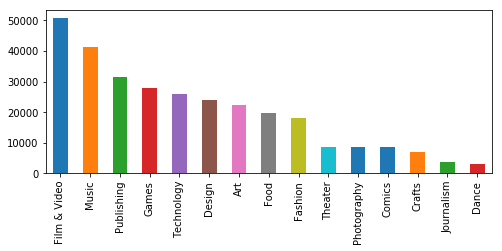

In [110]:
# メインカテゴリの割合
df_train['main_category'].value_counts().plot.bar(figsize=(8, 3))

state=trueの時のmain_category毎のカウント


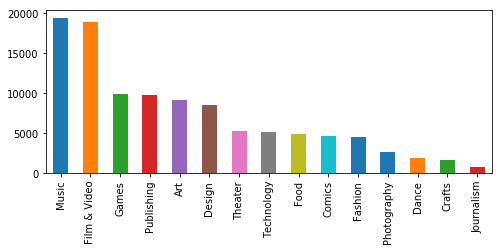

In [111]:
# 成功時のメインカテゴリの割合
df_train_1 = df_train[df_train['state']] 
print("state=trueの時のmain_category毎のカウント")
df_train_1['main_category'].value_counts().plot.bar(figsize=(8, 3))

→　Musicは約５０％近く成功している

In [112]:
# カテゴリ変数をダミー変数に変換（One-Hotベクトル）

# main_category
df_train = pd.concat([df_train, pd.get_dummies(df_train['main_category'])], axis=1)
df_train = df_train.drop(['category','main_category'], axis=1)
df_train.head()

,currency,country,usd_goal_real,state,day_diff,name_word_len,Art,Comics,Crafts,Dance,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,USD,US,5000.0,False,30,5,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,USD,US,20000.0,False,60,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,USD,US,15000.0,False,30,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,USD,US,15000.0,False,60,7,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,USD,US,20000.0,False,32,7,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [113]:
# テストデータも実施
df_X_test = pd.concat([df_X_test, pd.get_dummies(df_X_test['main_category'])], axis=1)
df_X_test = df_X_test.drop(['category','main_category'], axis=1)

次にcountryについても実施

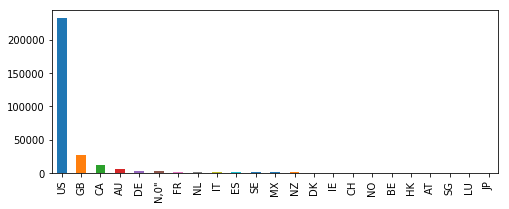

In [114]:
df_train['country'].value_counts().plot.bar(figsize=(8, 3))

state=1の時のcountry毎のカウント


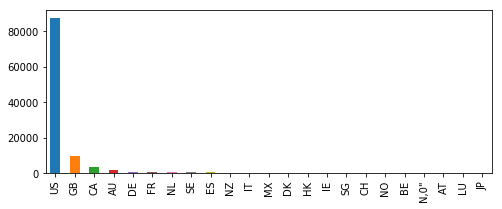

In [115]:
print("state=1の時のcountry毎のカウント")
df_train_1['country'].value_counts().plot.bar(figsize=(8, 3))

→　USがデータの大部分を占めていることがわかる

In [116]:
# カテゴリ変数をダミー変数に変換（One-Hotベクトル）
# country
df_train = pd.concat([df_train, pd.get_dummies(df_train['country'])], axis=1)
df_train = df_train.drop(['country'], axis=1)
df_train.head()

,currency,usd_goal_real,state,day_diff,name_word_len,Art,Comics,Crafts,Dance,Design,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,USD,5000.0,False,30,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,USD,20000.0,False,60,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,USD,15000.0,False,30,11,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,USD,15000.0,False,60,7,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,USD,20000.0,False,32,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [117]:
# テストデータも実施
df_X_test = pd.concat([df_X_test, pd.get_dummies(df_X_test['country'])], axis=1)
df_X_test = df_X_test.drop(['country'], axis=1)

次にcurrencyについて検討する

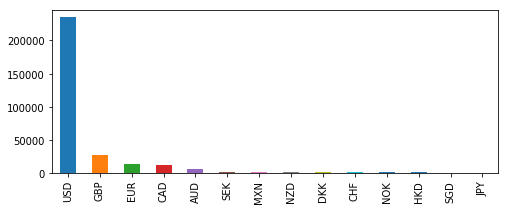

In [118]:
df_train['currency'].value_counts().plot.bar(figsize=(8, 3))

state=1の時のcountry毎のカウント


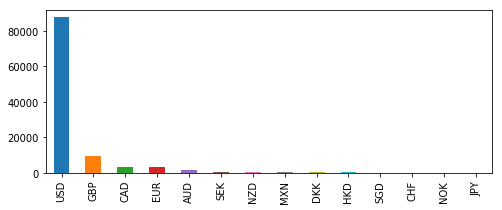

In [119]:
print("state=1の時のcountry毎のカウント")
df_train_1['currency'].value_counts().plot.bar(figsize=(8, 3))

county と currency はほぼ同じグラフとなり、相関が強いことが予想される。　→　currency を外す。

In [120]:
df_train = df_train.drop('currency', axis=1)
df_train.head()
df_X_test = df_X_test.drop('currency', axis=1)

- 外れ値チェック

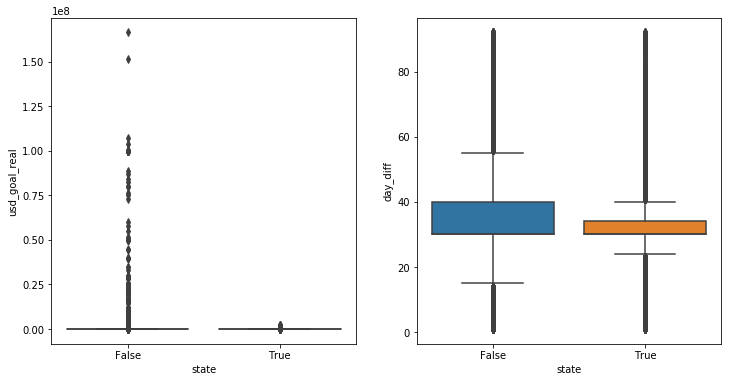

In [121]:
# 外れ値がないか確認
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_train, ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_train, ax=ax[1])

→　目標金額、募集期間共に金額等に開きはあるものの外れ値ではない

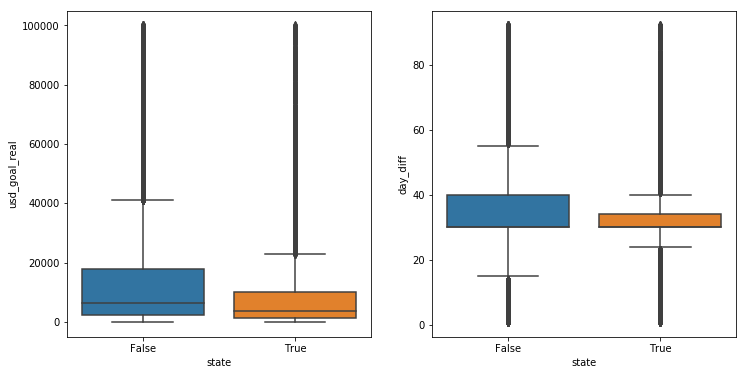

In [122]:
# 傾向を見る為、幅を狭める
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_train[df_train['usd_goal_real'] < 100000], ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_train, ax=ax[1])

→　少額の方がお金が集まりやすい。募集期間は約１ヶ月に設定しているものが多い。

In [123]:
# 統計量表示
display(df_train.describe())
# 相関係数を確認
display(df_train.corr())

,usd_goal_real,day_diff,name_word_len,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
count,3.006800e+05,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,...,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000,300680.000000
mean,4.580416e+04,34.158122,5.680813,0.074049,0.028592,0.023081,0.009868,0.079523,0.060157,0.168824,...,0.000090,0.000163,0.004373,0.010290,0.007546,0.001886,0.003821,0.004646,0.001427,0.773261
std,1.174885e+06,12.779267,2.749364,0.261851,0.166657,0.150161,0.098845,0.270554,0.237778,0.374597,...,0.009476,0.012765,0.065987,0.100917,0.086541,0.043384,0.061699,0.068004,0.037746,0.418723
min,1.000000e-02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+03,30.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.452210e+03,30.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.550000e+04,37.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.663614e+08,92.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,usd_goal_real,state,day_diff,name_word_len,Art,Comics,Crafts,Dance,Design,Fashion,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
usd_goal_real,1.000000,-0.023038,0.021075,-0.005613,-1.708291e-03,-0.005120,-0.004795,-0.003036,-0.000839,-0.005029,...,-2.127114e-04,-0.000137,-0.001751,-0.003573,0.006055,0.001189,-0.001453,-0.000577,-0.000972,-0.003161
state,-0.023038,1.000000,-0.116386,0.090642,3.204497e-02,0.066416,-0.036602,0.055672,-0.001529,-0.055722,...,-2.660754e-03,-0.000805,-0.015897,-0.069946,-0.025784,-0.011564,-0.005162,-0.009427,-0.000558,0.074445
day_diff,0.021075,-0.116386,1.000000,0.015874,-3.351346e-02,-0.000719,-0.030927,-0.007973,0.005794,-0.028466,...,-3.605315e-03,0.003104,0.012747,-0.010141,-0.003569,0.001460,-0.010713,-0.004186,-0.005825,0.034898
name_word_len,-0.005613,0.090642,0.015874,1.000000,-1.310282e-02,-0.006017,-0.026591,0.001983,0.061804,-0.011729,...,2.759752e-03,-0.000887,-0.016540,-0.012891,-0.008495,-0.007947,0.002348,-0.008291,0.008843,0.027021
Art,-0.001708,0.032045,-0.033513,-0.013103,1.000000e+00,-0.048516,-0.043467,-0.028231,-0.083120,-0.071545,...,9.138639e-07,0.000370,0.005510,-0.028835,-0.001764,-0.004094,-0.002693,-0.002698,-0.005642,0.012478
Comics,-0.005120,0.066416,-0.000719,-0.006017,-4.851604e-02,1.000000,-0.026371,-0.017127,-0.050427,-0.043405,...,-1.625809e-03,-0.000627,-0.002298,-0.017493,-0.012654,-0.001017,-0.006744,-0.006439,-0.002784,0.021937
Crafts,-0.004795,-0.036602,-0.030927,-0.026591,-4.346736e-02,-0.026371,1.000000,-0.015345,-0.045179,-0.038888,...,-1.456623e-03,-0.001962,0.005252,-0.015673,-0.000351,-0.001065,0.002685,-0.001708,0.009446,-0.007534
Dance,-0.003036,0.055672,-0.007973,0.001983,-2.823091e-02,-0.017127,-0.015345,1.000000,-0.029343,-0.025257,...,-9.460389e-04,-0.001275,0.001542,-0.009846,-0.003651,0.000314,-0.002366,-0.003852,-0.002882,0.019907
Design,-0.000839,-0.001529,0.005794,0.061804,-8.311993e-02,-0.050427,-0.045179,-0.029343,1.000000,-0.074363,...,3.700968e-03,0.001063,-0.005136,-0.029727,0.013432,0.002241,0.007696,0.005406,0.025690,-0.035388
Fashion,-0.005029,-0.055722,-0.028466,-0.011729,-7.154518e-02,-0.043405,-0.038888,-0.025257,-0.074363,1.000000,...,7.935142e-03,0.001153,-0.005322,-0.025381,0.011880,-0.001970,0.000653,0.004105,0.020823,-0.026514


In [124]:
# 散布図行列
# pd.plotting.scatter_matrix(df_train, figsize=(9,9))
# plt.show()

# 実行エラー
# TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

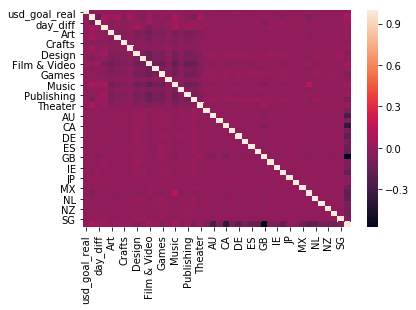

In [125]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_train.corr())
plt.show()

- 学習データ数が約30万件と多いため、学習データをランダムにサンプリングし、件数を減らす。（PCスペックに合わせる）

In [44]:
# サンプルデータをランダムに2万件取得　
df_train_a = df_train.sample(n=20000, random_state=1234)
df_train_a.head()

,usd_goal_real,state,day_diff,name_word_len,Art,Comics,Crafts,Dance,Design,Fashion,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
63722,1262.36,True,32,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
176426,4704.70,False,30,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127545,500.00,True,14,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248489,5597.98,False,40,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11628,500.00,True,30,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [126]:
df_train_a = df_train.copy()

### 学習用にデータをセット

In [127]:
df_X_train_1 = df_train_a.drop('state', axis=1)
X_train_1 = df_X_train_1.values
X_test_1 = df_X_test.values
y_train = df_train_a['state'].values

In [128]:
#データの標準化
scl = StandardScaler()
X_train_std = scl.fit_transform(X_train_1)
X_test_std = scl.transform(X_test_1)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


- X_train_1    : 学習用データ
- y_train       : 学習用ラベル 
- X_test_1    : テスト用データ
- y_test       : テスト用ラベル
- X_train_std : 学習用データ（標準化）
- X_test_std  : テスト用データ（標準化）

## ロジスティック回帰を使って学習

In [47]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train_std, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [48]:
# ラベルを予測
y_pred = clf.predict(X_test_std)

In [49]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
# 正答率を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -11.200
正答率（Accuracy） = 67.573%
適合率（Precision） = 70.043%
再現率（Recall） = 86.868%
F1値（F1-score） = 77.554%


In [50]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0,1]), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])
conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,42110,6366
正解 = 失敗,18010,8687


In [51]:
print("train score={:.3f}".format(clf.score(X_train_std, y_train)))
print("test score（Accuracy）={:.3f}".format(clf.score(X_test_std, y_test)))

train score=0.681
test score（Accuracy）=0.676


## サポートベクターマシーン

#### グリッドサーチ

In [52]:
%%time
#parameters = {'kernel':['rbf'], 'C':[1, 10], 'gamma':[1,10]}
# parameters = {'kernel':['rbf'], 'C':[0.5,1], 'gamma':[1]} 
parameters = {'kernel':['rbf'], 'C':[0.5], 'gamma':[0.5,1,1.5]} 

model = SVC()
gscv = GridSearchCV(model, parameters, cv=3,)
gscv.fit(X_train_std, y_train)
print(gscv.best_params_)
print(gscv.best_score_)

{'C': 0.5, 'gamma': 0.5, 'kernel': 'rbf'}
0.66815
CPU times: user 3min 58s, sys: 1.85 s, total: 4min
Wall time: 4min


In [53]:
# 最適パラメータを用いて識別する
svc = SVC(**gscv.best_params_)
svc.fit(X_train_std, y_train)
print("train score={:.3f}".format(svc.score(X_train_std, y_train)))
print("test score（Accuracy）={:.3f}".format(svc.score(X_test_std, y_test)))

train score=0.680
test score（Accuracy）=0.667


### Lasso(L1正則化)による特徴選択

In [54]:
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [55]:
# fitで特徴選択を実行
sfm.fit(X_train_std, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [56]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False,  True,  True])

In [57]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_X_train_1.columns[removed_idx]

Index(['Design', 'Games', 'CA', 'CH', 'MX', 'NO', 'SE'], dtype='object')

In [58]:
# LASSOで得た各特徴の係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)

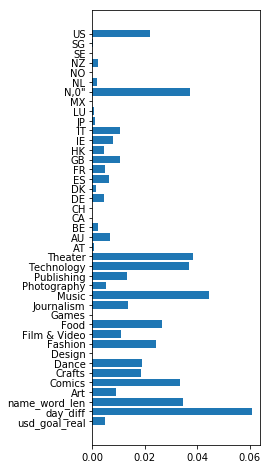

In [59]:
# 係数を棒グラフで表示
fig, axes = plt.subplots(figsize=(3, 8))
axes.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_X_train_1.columns.values)
plt.show()

### ステップワイズ法による特徴選択

In [60]:
estimator = LogisticRegression()
# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定
rfecv = RFECV(estimator, cv=10, scoring='accuracy')

In [61]:
# fitで特徴選択を実行
rfecv.fit(X_train_std, y_train)

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [62]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[ 1  1  1  9  1  1  1 14  1  4  1 13  1  1  1  1  1  1 16  3  8 17 21  5
 11  2  1  1  6  1  1  1 10 20  1 15 19  7 18 12  1]


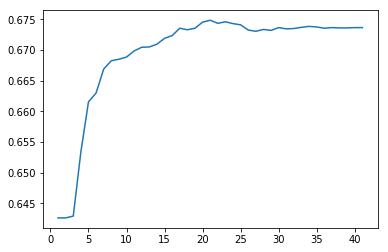

In [63]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [64]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([ True,  True,  True, False,  True,  True,  True, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True,  True, False, False,  True, False,
       False, False, False, False,  True])

In [65]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([False, False, False,  True, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True,  True, False])

In [66]:
# 削除してもよい特徴の名前を取得する
remove_feature = df_X_train_1.columns[remove_idx]
remove_feature

Index(['Art', 'Design', 'Film & Video', 'Games', 'AT', 'AU', 'BE', 'CA', 'CH',
       'DE', 'DK', 'ES', 'HK', 'LU', 'MX', 'NL', 'NO', 'NZ', 'SE', 'SG'],
      dtype='object')

In [67]:
# drop関数で特徴を削除
selected_train_data = df_X_train_1.drop(remove_feature, axis=1)
selected_test_data = df_X_test.drop(remove_feature, axis=1)
X_s_train = selected_train_data.values
X_s_test = selected_test_data.values

In [68]:
# 再度データの標準化
scl = StandardScaler()
X_train_std = scl.fit_transform(X_s_train)
X_test_std = scl.transform(X_s_test)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


再度ロジスティック回帰を実施

In [69]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=123)
clf.fit(X_train_std, y_train)

# ラベルを予測
y_pred = clf.predict(X_test_std)

print("train score={:.3f}".format(clf.score(X_train_std, y_train)))
print("test score(Accuracy)={:.3f}".format(clf.score(X_test_std, y_test)))

train score=0.680
test score(Accuracy)=0.676


## ランダムフォレスト

In [78]:
%%time
param_grid = {"max_depth":[10,None],"n_estimators":[400,1000], "min_samples_leaf":[3,4,5], "min_samples_split":[2,3],"criterion":["gini"]}

forest_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=1234),
                                                 param_grid = param_grid, scoring="accuracy", cv=3, n_jobs=1)

forest_grid.fit(X_s_train, y_train)

print(forest_grid.best_params_)
print(forest_grid.best_score_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}
0.6829
CPU times: user 6min 43s, sys: 3.08 s, total: 6min 46s
Wall time: 6min 47s


In [79]:
# 最適パラメータを用いて識別する
rfc = RandomForestClassifier(**forest_grid.best_params_)
rfc.fit(X_train_std, y_train)
print("train score={:.3f}".format(rfc.score(X_train_std, y_train)))
print("test score（Accuracy）={:.3f}".format(rfc.score(X_test_std, y_test)))

train score=0.745
test score（Accuracy）=0.682


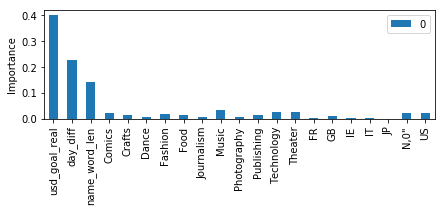

In [80]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print(clf.feature_importances_)
pd.DataFrame(rfc.feature_importances_, index=selected_train_data.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.show()

### ニューラルネットワーク

In [131]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(41, activation='relu', input_dim=41))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Train on 300680 samples, validate on 75173 samples
Epoch 1/50
300680/300680 [==============================] - 28s 93us/step - loss: 0.6124 - acc: 0.6660 - val_loss: 0.6084 - val_acc: 0.6672
Epoch 2/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6084 - acc: 0.6701 - val_loss: 0.6082 - val_acc: 0.6717
Epoch 3/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6064 - acc: 0.6706 - val_loss: 0.6045 - val_acc: 0.6721
Epoch 4/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6045 - acc: 0.6708 - val_loss: 0.6033 - val_acc: 0.6709
Epoch 5/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6029 - acc: 0.6719 - val_loss: 0.6030 - val_acc: 0.6736
Epoch 6/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6018 - acc: 0.6721 - val_loss: 0.6006 - val_acc: 0.6753
Epoch 7/50
300680/300680 [==============================] - 24s 80us/step - loss: 0.6005 - acc: 0.6732 - val_

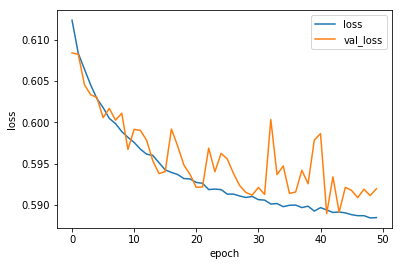

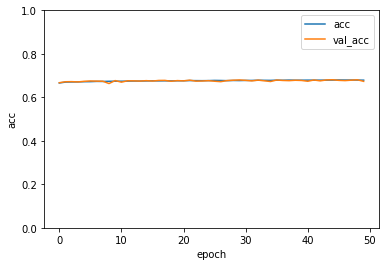

In [132]:
# one-hotベクトルに変換
y_train_c = np_utils.to_categorical(y_train)
y_test_c = np_utils.to_categorical(y_test)

# 計算の実行
fit = model.fit(X_train_std, y_train_c,
          epochs=50,
          batch_size=20,validation_data=(X_test_std, y_test_c))

# 各epochにおける損失と精度をdfに入れる
df_nn = pd.DataFrame(fit.history)

# グラフ化
df_nn[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df_nn[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

→　accuracyが（少しだけ上がったが）ほとんど変わらない結果となった。

### 最も良いAccuracyは、0.682。ランダムフォレストを用いてモデルを構築した時でした。